In [15]:
import pandas as pd
import networkx as nx

In [16]:
# Saccharomyces cerevisiae

string_df_4932 = pd.read_csv("organismos_string/4932_protein_cerevisiae.txt", sep=" ")
string_df_4932

,protein1,protein2,combined_score
0,4932.Q0010,4932.YPL135W,347
1,4932.Q0010,4932.Q0017,945
2,4932.Q0010,4932.YOL103W,163
3,4932.Q0010,4932.YJR122W,528
4,4932.Q0010,4932.YGL043W,284
...,...,...,...
1988587,4932.YPR204W,4932.YPR137C-A,169
1988588,4932.YPR204W,4932.YDR316W-A,282
1988589,4932.YPR204W,4932.YDR215C,315
1988590,4932.YPR204W,4932.YAL017W,152


## Funções dos grafos

In [17]:
# protein_interaction_df = string_df_4932

protein_interaction_df = string_df_4932

In [18]:
# Enumerando as proteínas da Cerevisiae

protein_map = { v:k for k, v in enumerate(set(protein_interaction_df.loc[:, "protein1"]).union(
    set(protein_interaction_df.loc[:, "protein2"]))) }


print(len(protein_map))

6394


In [19]:
protein_map

{'4932.YBR182C': 0,
 '4932.YMR158W': 1,
 '4932.YKL023W': 2,
 '4932.YLR054C': 3,
 '4932.YGL216W': 4,
 '4932.YAL047C': 5,
 '4932.YFL041W': 6,
 '4932.YML098W': 7,
 '4932.YMR264W': 8,
 '4932.YLR011W': 9,
 '4932.YPL014W': 10,
 '4932.YOR383C': 11,
 '4932.YDL173W': 12,
 '4932.YGL123W': 13,
 '4932.YOL018C': 14,
 '4932.YDL189W': 15,
 '4932.YBR269C': 16,
 '4932.YLR027C': 17,
 '4932.YFR035C': 18,
 '4932.YNL273W': 19,
 '4932.YHL038C': 20,
 '4932.YGR216C': 21,
 '4932.YGR221C': 22,
 '4932.YNL212W': 23,
 '4932.YER090W': 24,
 '4932.YNL090W': 25,
 '4932.YOL108C': 26,
 '4932.YKL146W': 27,
 '4932.YDR205W': 28,
 '4932.YNL086W': 29,
 '4932.YOR052C': 30,
 '4932.YLR149C-A': 31,
 '4932.YGR208W': 32,
 '4932.YER064C': 33,
 '4932.YNL001W': 34,
 '4932.YJL222W-A': 35,
 '4932.YLR198C': 36,
 '4932.YJR075W': 37,
 '4932.YDR216W': 38,
 '4932.YPL173W': 39,
 '4932.YPR033C': 40,
 '4932.YDL183C': 41,
 '4932.YOL149W': 42,
 '4932.YOL014W': 43,
 '4932.YJR101W': 44,
 '4932.YDR302W': 45,
 '4932.YMR192W': 46,
 '4932.YOR099W': 47

In [20]:
# Mapeando as proteínas para gerar o grafo

def mapProtein(protein_interaction_df, protein_map):
    
    protein_interation_masked = pd.DataFrame()
    
    proteins = ['protein1', 'protein2']
    
    for p in proteins:
        protein_interation_masked[p] = protein_interaction_df[p].map(protein_map)
    
    return protein_interation_masked

In [21]:
protein_interation_masked = mapProtein(protein_interaction_df, protein_map)
protein_interation_masked

,protein1,protein2
0,571,4969
1,571,3129
2,571,3033
3,571,4337
4,571,4190
...,...,...
1988587,2605,4571
1988588,2605,672
1988589,2605,1400
1988590,2605,5443


In [22]:
def generateGraph(protein_interation_masked):

    # Gerar grafo a partir do mapeamento do dataframe do Pandas
    protein_interaction_graph = nx.from_pandas_edgelist(
        protein_interation_masked, 
        source = "protein1", 
        target = "protein2"
    )
    
    return protein_interaction_graph

In [23]:
def generateDF(protein_interaction_graph):
    return nx.to_pandas_edgelist(protein_interaction_graph)

In [24]:
# Geração do grafo de PPI

graph = generateGraph(protein_interation_masked)
df_graph = generateDF(graph)
df_graph

,source,target
0,571,4969
1,571,3129
2,571,3033
3,571,4337
4,571,4190
...,...,...
994291,863,5025
994292,6303,1606
994293,2108,327
994294,239,2802


In [25]:
# Medidas de Centralidade
import time

seconds_ini = time.time()

# Degree Centrality
degree = nx.degree_centrality(graph)

In [26]:
# Eigenvector Centrality
eigenvector = nx.eigenvector_centrality(graph)

In [27]:
# Betweenness Centrality
betweenness = nx.betweenness_centrality(graph)

In [28]:
# Closeness Centrality
closeness = nx.closeness_centrality(graph)

In [29]:
# Clustering
clustering = nx.clustering(graph)

seconds_fini = time.time()

print("Seconds since epoch =", seconds_fini - seconds_ini)

Seconds since epoch = 3769.640370130539


In [30]:
# Criando um Dataframe
from collections import OrderedDict

degree_ordered = OrderedDict(sorted(degree.items()))
eigenvector_ordered = OrderedDict(sorted(eigenvector.items()))
betweenness_ordered = OrderedDict(sorted(betweenness.items()))
closeness_ordered = OrderedDict(sorted(closeness.items()))
clustering_ordered = OrderedDict(sorted(clustering.items()))


protein_features = pd.concat([pd.Series(list(protein_map.keys())),
                              pd.Series(list(degree_ordered.values())), 
                              pd.Series(list(eigenvector_ordered.values())),
                              pd.Series(list(betweenness_ordered.values())), 
                              pd.Series(list(closeness_ordered.values())),
                              pd.Series(list(clustering_ordered.values()))], axis=1)

protein_features.columns = ["Protein_key",
                            "DegreeCentrality",
                            "EigenvectorCentrality",
                            "BetweennessCentrality",
                            "ClosenessCentrality",
                            "Clustering"]
                           

In [31]:
protein_features

,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering
0,4932.YBR182C,0.059909,0.009397,1.233359e-04,0.499687,0.313084
1,4932.YMR158W,0.090568,0.023854,7.005906e-05,0.506416,0.479887
2,4932.YKL023W,0.008603,0.001296,1.071163e-05,0.462122,0.236364
3,4932.YLR054C,0.006257,0.000445,7.120056e-06,0.443589,0.289744
4,4932.YGL216W,0.083060,0.012795,2.988854e-04,0.506938,0.273937
...,...,...,...,...,...,...
6389,4932.YMR010W,0.020648,0.002403,4.499981e-05,0.475918,0.193847
6390,4932.YMR026C,0.043172,0.005179,1.245902e-04,0.491845,0.181686
6391,4932.YMR244W,0.002972,0.000226,3.814570e-07,0.395925,0.233918
6392,4932.YDL113C,0.041764,0.004499,8.969398e-05,0.486937,0.242178


In [32]:
# Rotulando as proteínas essencias

dataset_essential = pd.read_csv('essential_genes.csv')

In [33]:
sac_proteins = list(dataset_essential[dataset_essential['Code_Organism'] == 'DEG2001']['Locus'])

protein_features['is_essential'] = protein_features.apply(lambda x: 1 if x.Protein_key in sac_proteins 
                                                          else 0, axis=1)

In [34]:
protein_features

,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,is_essential
0,4932.YBR182C,0.059909,0.009397,1.233359e-04,0.499687,0.313084,0
1,4932.YMR158W,0.090568,0.023854,7.005906e-05,0.506416,0.479887,0
2,4932.YKL023W,0.008603,0.001296,1.071163e-05,0.462122,0.236364,0
3,4932.YLR054C,0.006257,0.000445,7.120056e-06,0.443589,0.289744,0
4,4932.YGL216W,0.083060,0.012795,2.988854e-04,0.506938,0.273937,0
...,...,...,...,...,...,...,...
6389,4932.YMR010W,0.020648,0.002403,4.499981e-05,0.475918,0.193847,0
6390,4932.YMR026C,0.043172,0.005179,1.245902e-04,0.491845,0.181686,0
6391,4932.YMR244W,0.002972,0.000226,3.814570e-07,0.395925,0.233918,0
6392,4932.YDL113C,0.041764,0.004499,8.969398e-05,0.486937,0.242178,0


In [35]:
protein_features.to_csv('proteins_features_cerevisiae.csv', index=False)

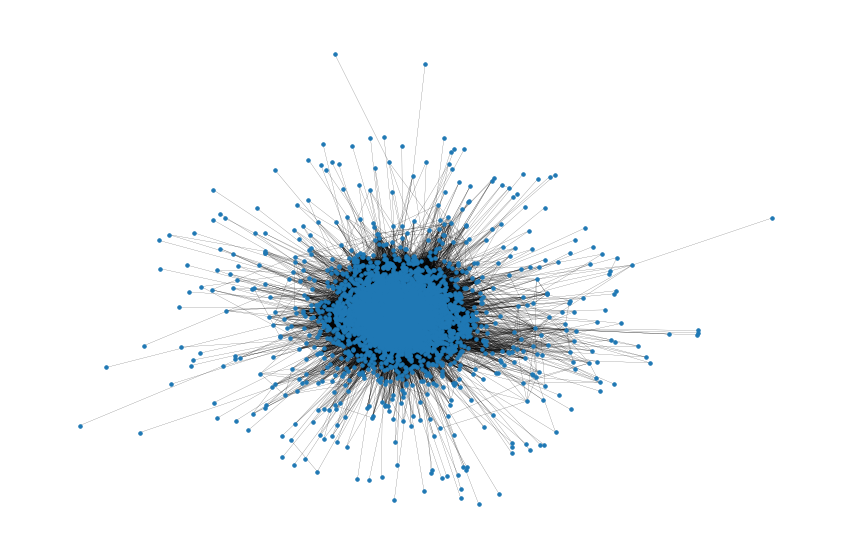

In [36]:
# Graph 

# Fonte: https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html

from random import randint
import matplotlib.pyplot as plt

pos = nx.spring_layout(graph)


plt.figure(figsize=(15,10))
plt.axis('off') 
nx.draw_networkx(graph, pos=pos, node_size=12, with_labels=False, width=0.15)

### Visualização de dados

In [37]:
df = pd.read_csv("proteins_features_cerevisiae.csv")
df

,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,is_essential
0,4932.YBR182C,0.059909,0.009397,1.233359e-04,0.499687,0.313084,0
1,4932.YMR158W,0.090568,0.023854,7.005906e-05,0.506416,0.479887,0
2,4932.YKL023W,0.008603,0.001296,1.071163e-05,0.462122,0.236364,0
3,4932.YLR054C,0.006257,0.000445,7.120056e-06,0.443589,0.289744,0
4,4932.YGL216W,0.083060,0.012795,2.988854e-04,0.506938,0.273937,0
...,...,...,...,...,...,...,...
6389,4932.YMR010W,0.020648,0.002403,4.499981e-05,0.475918,0.193847,0
6390,4932.YMR026C,0.043172,0.005179,1.245902e-04,0.491845,0.181686,0
6391,4932.YMR244W,0.002972,0.000226,3.814570e-07,0.395925,0.233918,0
6392,4932.YDL113C,0.041764,0.004499,8.969398e-05,0.486937,0.242178,0


In [38]:
df_essential = df[df['is_essential'] == 1]
df_essential

,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,is_essential
7,4932.YML098W,0.036915,0.006046,0.000045,0.489998,0.265849,1
13,4932.YGL123W,0.149226,0.038106,0.000350,0.529309,0.360022,1
21,4932.YGR216C,0.026279,0.003119,0.000043,0.481328,0.178001,1
40,4932.YPR033C,0.139840,0.032728,0.000667,0.524059,0.306019,1
42,4932.YOL149W,0.048334,0.009369,0.000077,0.495082,0.257576,1
...,...,...,...,...,...,...,...
6369,4932.YOR181W,0.054747,0.007258,0.000122,0.496081,0.271650,1
6373,4932.YIL083C,0.040044,0.006134,0.000090,0.487866,0.228278,1
6376,4932.YFR031C,0.093383,0.016652,0.000153,0.511399,0.294920,1
6380,4932.YPR168W,0.022525,0.003194,0.000034,0.470212,0.308372,1


In [39]:
df_non_essential = df[df['is_essential'] == 0]
df_non_essential

,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,is_essential
0,4932.YBR182C,0.059909,0.009397,1.233359e-04,0.499687,0.313084,0
1,4932.YMR158W,0.090568,0.023854,7.005906e-05,0.506416,0.479887,0
2,4932.YKL023W,0.008603,0.001296,1.071163e-05,0.462122,0.236364,0
3,4932.YLR054C,0.006257,0.000445,7.120056e-06,0.443589,0.289744,0
4,4932.YGL216W,0.083060,0.012795,2.988854e-04,0.506938,0.273937,0
...,...,...,...,...,...,...,...
6388,4932.YAR050W,0.031441,0.002970,1.305599e-04,0.489660,0.160995,0
6389,4932.YMR010W,0.020648,0.002403,4.499981e-05,0.475918,0.193847,0
6390,4932.YMR026C,0.043172,0.005179,1.245902e-04,0.491845,0.181686,0
6391,4932.YMR244W,0.002972,0.000226,3.814570e-07,0.395925,0.233918,0


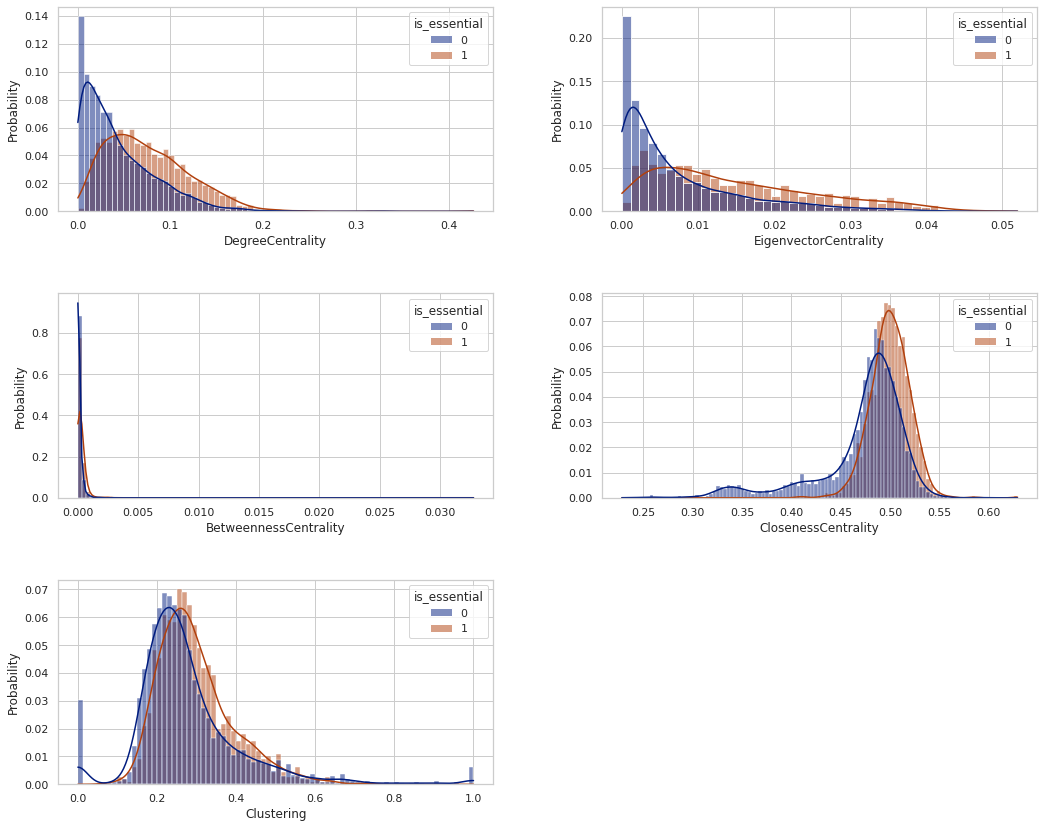

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (16,12)

# Define as configurações dos plots
# Cada plot terá o mesmo tamanho de figuras (8,10)
#plt.style.use("ggplot")

plt.figure(1)

sns.set_theme(style="whitegrid", palette="dark")


# Dados para cada subplot

plt.subplot(321)
sns.histplot(data=df, x="DegreeCentrality", hue="is_essential", 
             stat="probability", common_norm=False, kde=True)

plt.subplot(322)
sns.histplot(data=df, x="EigenvectorCentrality", hue="is_essential", 
            stat="probability", common_norm=False, kde=True)

plt.subplot(323)
sns.histplot(data=df, x="BetweennessCentrality", hue="is_essential", bins = 100,
            stat="probability", common_norm=False, kde=True)

plt.subplot(324)
sns.histplot(data=df, x="ClosenessCentrality", hue="is_essential", 
            stat="probability", common_norm=False, kde=True)

plt.subplot(325)
sns.histplot(data=df, x="Clustering", hue="is_essential", 
            stat="probability", common_norm=False, kde=True)


plt.subplots_adjust(top=0.95, bottom=0.05, left=0.10, right=0.95, hspace=0.4,
                    wspace=0.25)

plt.savefig("results.jpg")
plt.show()
